# Boilerplate, loading data, and the like

In [1]:
### Importing modules

%pylab
%matplotlib inline
rc('text', usetex = False)
import pandas as pd
import os
import os.path as osp
import sys
import inspect
import cPickle
from urllib import urlretrieve
from zipfile import ZipFile
sys.path.append(osp.join(os.getcwd(),'utilities','lib', 'python2.7','site-packages'))
import seaborn
seaborn.set()

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
### Local modules included in this directory (chains.py stripped from CosmoSlik, which was used to
# generate chains)

cmd_subfolder = osp.realpath(os.path.abspath(os.path.join(os.path.split(inspect.getfile( inspect.currentframe() ))[0],"utilites")))
if cmd_subfolder not in sys.path:
    sys.path.insert(0, cmd_subfolder)
from utilities.chains import load_chain
from utilities.helper_functions import get_data,like1d,likelihood
#from cosmoslik_plugins.samplers.metropolis_hastings import load_chain

In [ ]:
### Download the chains if they're not in the directory already
for filename in ['r16_treatment_thinned.chain', 
             'base_thinned.chain', 
             'base_manypops_thinned.chain',
             'varyR_thinned.chain',
             'varyR_manypops_thinned.chain',
             'varyR_no_correction_thinned.chain'
            ]:
    if filename not in os.listdir(osp.join(os.getcwd(), 'data', 'chains')):
        print 'file %s not found. Downloading chains'%filename                          
        handle, _ = urlretrieve('https://www.dropbox.com/s/kq8y6zsrtkt3fer/required_chains.zip?dl=1', 
                                osp.join(os.getcwd(), 'data', 'chains','chains.zip')
                               )
        ZipFile(handle).extractall(path = osp.join(os.getcwd(), 'data', 'chains'))
    else:
        pass

# Overview:

## 1. Introduction and Data Exploration
* What is a Cepheid variable star, and what is a supernova?
* Getting an overall picture of the data
    * Clustering
* How to start working with data when you don't really know what it is.

## 2. First Stabs at a Model: 10 minute tests
* Linear Model
* Random Forest
* Linear Model with Cross Terms

## 3. Estimating Errors
* *In-sample* errors
* *Infinitesimal Jackknife* (bootstrap) errors
* Why you really just need a statistical model
 
## 4. Building a Statistical Model
* MCMC
* Incorporating Domain-specific knowledge
* Results

# An Early Universe Cosmologist Explores the Implications of Variable Stars for the Current Rate of Cosmic Expansion

### Abstract:
*Local measurements of the rate of cosmic expansion today from Cepheid variable stars (Riess et. al. 2016) are in $\sim 3 \sigma$ tension with Cosmic Microwave Background-derived inferences of the same quantity under the standard cosmological concordance model. This tension, if unexplained by systematic effects in either dataset, is evidence for new physics. In this talk, I will discuss my attempts to make sense of the variable star analysis and its assumptions, particularly in its inference of Cepheid brightness. In this talk, framed by a Jupyter Notebook available in advance by email request, I will highlight the toolbox I used for data exploration, which may be of general interest to students interested in learning how to approach academic research with an eye to a future career in industrial data science or data analysis.*
## Introduction:

### The basic problem:

Local measurements based on Cepheid Variable Stars say

### $$H_0 = \left(73.24 \pm 1.74\right) {\rm \frac{km/sec}{Mpc}}$$

High redshift measurements of the Cosmic Microwave Background say

### $$H_0 = \left(69.3 \pm 0.7 \right) {\rm \frac{km/sec}{Mpc}}$$

Who's right? I know how the CMB measurement comes about, but I want to build intuition about the Local (Riess et. al) measurement.

### Distance Ladder
Three rungs:
* So-called **geometric** measures to galaxies with parallax measurements or analogues
    * Milky Way Cepheids
    * Eclipsing binary star systems in the LMC
    * water *mega-maser* in NGC4258
    * there are more, but not included in the analysis
* Cepheid calibration of above anchor galaxies to cepheid host galaxies with type Ia Supernovae
    * 19 galaxies with Cepheids measured using Hubble Wide Field Camera 3.
    * ~2000 cepheids in total
* Supernovae calibration from these cepheid host galaxies is used obtain a type Ia absolute magnitude scale, to calibrate the known supernovae redshift magnitude relationship trained on $\sim 300$ supernovae at $0.023 < z < 0.15$


<img src = "figures/my_distance_ladder_sm.gif" width="800" />

## First Exploration of the Data
Let's look at the data used to make the local Hubble constraint. This consists of Cepheid variable stars, and type Ia supernovae, in the galaxies in the table above, plus the Milky Way and LMC.

In [3]:
# Load the data from a scrape of a tab seperated table R16 use to do their analysis (table 4 of R16)
cepheids, sne = get_data() # a helper function in the utilities folder to load cepheids and sne into dataframes

Let's look at the characteristics we have for each of these objects:

,Field,RA,DEC,ID,Period,VminusI,m_H,sigma_tot,Z,parallax,p_err,LK
0,m101,210.87979,54.33376,115287,17.950,0.96,22.47,0.302,9.134,NaN,NaN,NaN
1,m101,210.89127,54.35620,136682,5.358,1.06,24.41,0.569,9.118,NaN,NaN,NaN
2,m101,210.89227,54.36125,148312,11.860,1.07,22.94,0.323,9.113,NaN,NaN,NaN
3,m101,210.89351,54.36826,164932,14.920,1.13,23.03,0.322,9.105,NaN,NaN,NaN
4,m101,210.87982,54.33565,121146,11.860,0.96,23.14,0.448,9.136,NaN,NaN,NaN


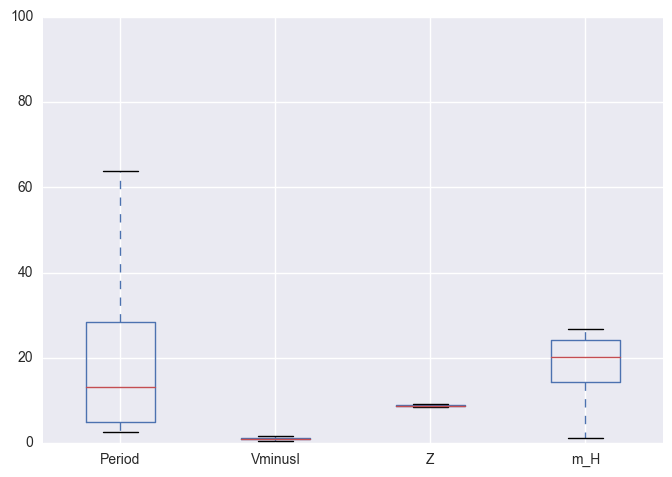

In [4]:
cepheids[['Period', 'VminusI', 'Z','m_H']].plot.box()
#gca().set_yscale('log')
cepheids.head(5)

First thing we notice is that the distribution of 'Period' and '$m_H$' are much wider than the other features. We're tempted to transoform them to make them more like the others (since predictives work better when they're not forced to train on features with very disparate scales), but, recallling we have a categorical feature 'Field' that we haven't even looked at yet, we should first check if there's correlation with the categorical.

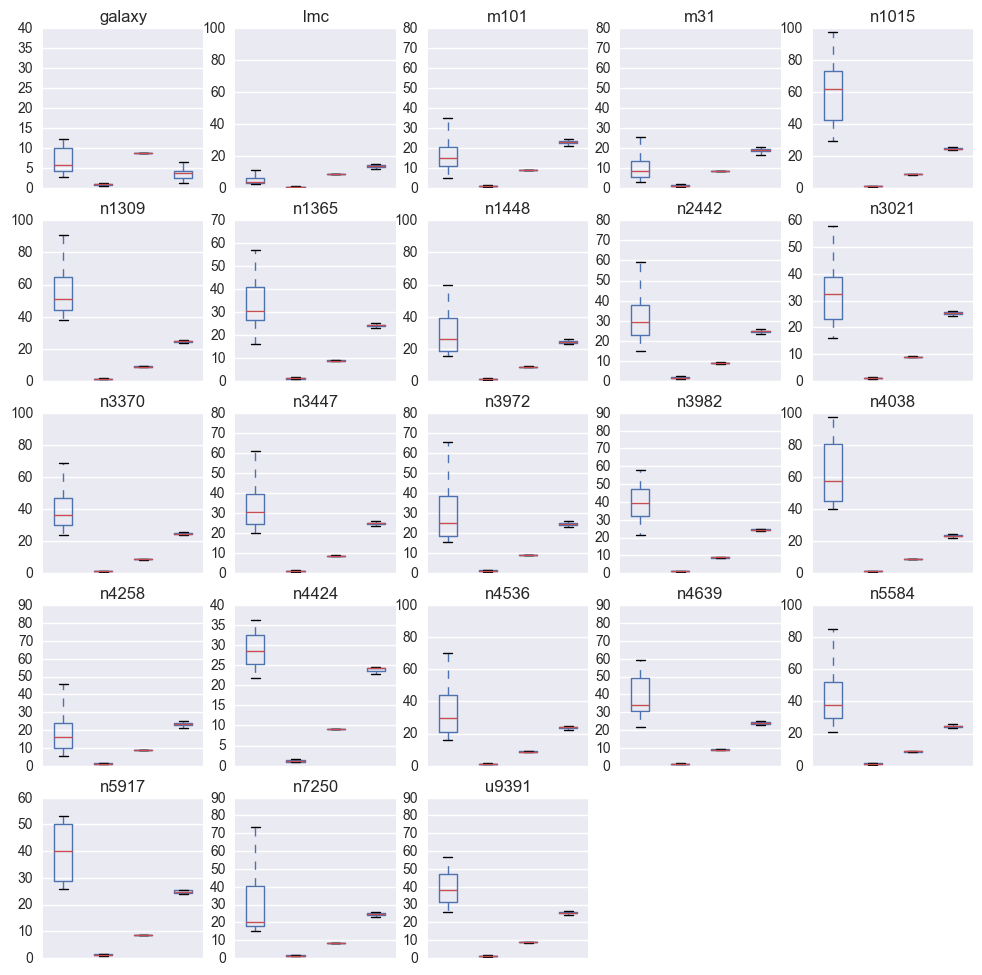

In [5]:
figure(figsize = (12,12))
grouped = cepheids.groupby('Field')
for i, (name, group) in enumerate(grouped):
    group[['Period', 'VminusI', 'Z','m_H']].plot.box(ax = subplot(5,5,i+1), title = name)
    gca().set_xticks([], [])
    hold('on')
    
show()

Definitely the variance in period is much bigger than the variance in other parameters. Let's correct that.

We can either divide by the range (a good choice generally), or since the periods are always positive, we can just take the log.

,Field,RA,DEC,ID,Period,VminusI,m_H,sigma_tot,Z,parallax,p_err,LK
0,m101,210.87979,54.33376,115287,0.254064,0.96,22.47,0.302,0.234,NaN,NaN,NaN
1,m101,210.89127,54.35620,136682,-0.270997,1.06,24.41,0.569,0.218,NaN,NaN,NaN
2,m101,210.89227,54.36125,148312,0.074085,1.07,22.94,0.323,0.213,NaN,NaN,NaN
3,m101,210.89351,54.36826,164932,0.173769,1.13,23.03,0.322,0.205,NaN,NaN,NaN
4,m101,210.87982,54.33565,121146,0.074085,0.96,23.14,0.448,0.236,NaN,NaN,NaN


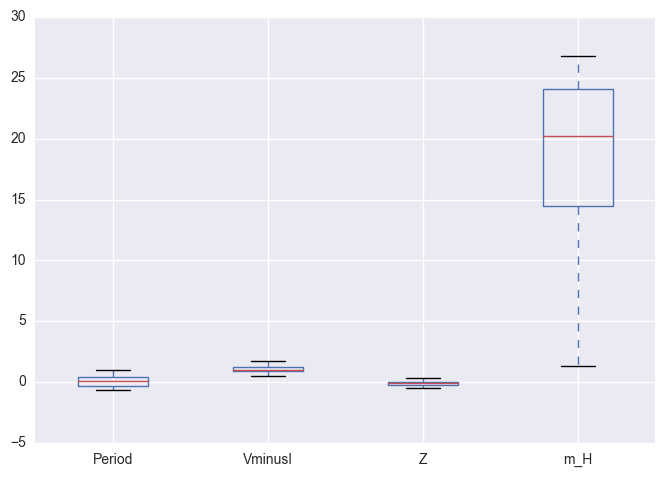

In [6]:
cepheids['Period'] = log10(cepheids['Period']) - 1
cepheids['Z'] = cepheids['Z'] - 8.9

cepheids[['Period', 'VminusI', 'Z','m_H']].plot.box()
#gca().set_yscale('log')
cepheids.head(5)

The supernovae for this analysis turn out to be just a single feature: the $m^B_0$ of each supernovae, and an error on that measurement.

(of course, this isn't actually true--there's a lot of interesting things that go into that $m^B_0$, but it was outside the scope of what I did)

In [7]:
sne.describe()

,m^B_0,SN_err
count,19.000000,19.000000
mean,12.387816,0.118632
std,0.841766,0.006970
min,9.746500,0.109000
25%,12.216000,0.115000
50%,12.419000,0.116000
75%,12.937500,0.120500
max,13.470000,0.142000


## What do these features mean?
Reading the paper (https://arxiv.org/abs/1604.01424), we learn:

Cepheids:
* Field (categorical): the host galaxy for the cepheid
* RA/DEC: Right ascension/declination (location in the sky). Mostly just tells us what galaxy we're in, so degenerate with above
* ID: unique Cepheid ID (for what catalogue I'm not sure--**I'd like to know**)
* Period: The period of Cepheid variation
* $V-I$: The color of a cepheid, defined by the difference in magnitude between V (visible) and I (infrared) measurements
* $m_H$: the magnitude (log brightness) in the Hubble WFC3 H band (chosen to reduce systematics due to dust)
* $\sigma_{\rm tot}$: the total error on the H band magnitude from all sources as determined by R16
    * crowding error $\sigma_{\rm sky}$: incorrectly assigning photons from other objects to the Cepheid (or overcorrection of said)
    * color error $\sigma_{\rm ct}$: variations in the magnitude estimate in V versus I due to Cepheid blending
    * phase error $\sigma_{\rm ph}$: where in the period the cepheid is when measured can change its magnitude.
    * intrinsic dispersion $\sigma_{\rm int}$: not actually error, but stochastic contribution to cepheid magnitude.
  Total error is given by $$\sigma_{\rm tot}^2 = \sigma_{\rm sky}^2 + \sigma_{\rm ct}^2 + \sigma_{\rm int}^2 +\left( \sigma_{\rm ph} f_{\rm ph}\right)^2,$$ where $f_{\rm ph}$ is the fraction of a period unobserved.
* Z: metallicity as defined by $log_{10}[O/H]$
* Parallax: Geometric parallax measure (for Milky Way Cepheids only)
* p_err: error on parallax. Leads to an error in magnitude (distance modulus) space by $\sigma_{\rm mag} = \frac{5}{\ln 10} \frac{\sigma_p}{parallax}$
* LK: So called Lutz-Kelker corrections to distance modulii from parallax measurements. The equation is
$$\mu_{\pi} = 5 \log_{10} \left(\frac{10^{-3}}{Parallax}\right) + 25 - LK$$
  
  
  
Supernovae:
* Host: the host galaxy for the supernovae
* sne: the supernovae name
* $m^B_0$: the measured B band magnitude at peak brightness
* err: the error on this measurement.

## Feature Engineering. 
Let's implement the equations in the above into the dataframes, and drop irrelevant features:


In [8]:
cepheids['mu_pi'] = 5 * log10(10**-3/cepheids.parallax) + 25 - cepheids.LK

cepheids['TotalError'] = sqrt(cepheids.sigma_tot**2 
                              + (cepheids.p_err.fillna(0) / cepheids.parallax.fillna(1) * 5/log(10))**2)


## And get rid of columns we don't want
cepheids_processed = cepheids.drop(['RA', 'DEC', 'ID', 
                                    'parallax', 'p_err', 'LK', 
                                    'sigma_tot'], axis = 1);


## View on Category (Field/Host)
To get a better idea of the data, let's split the sample into individual galaxies. First, a count of Cepheids in each galaxy:

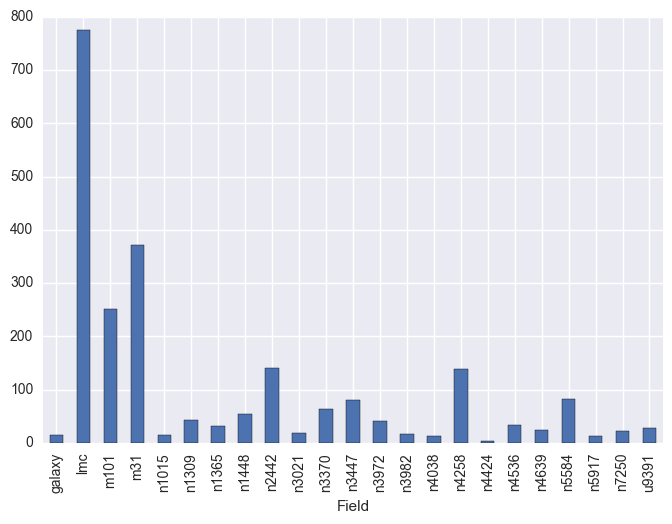

In [9]:
cepheid_count = cepheids_processed.groupby('Field')['Field'].count().plot.bar()
#cepheid_count ## Pick a specific value using cepheid_count.<field>

Lastly, we can look at correlation between variables, both overall and in each galaxy:

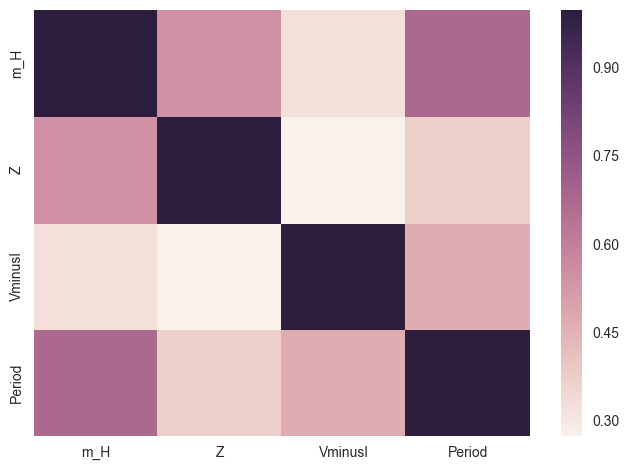

In [10]:
corr = cepheids_processed[['m_H', 'Z', 'VminusI', 'Period']].corr()
seaborn.heatmap(corr)

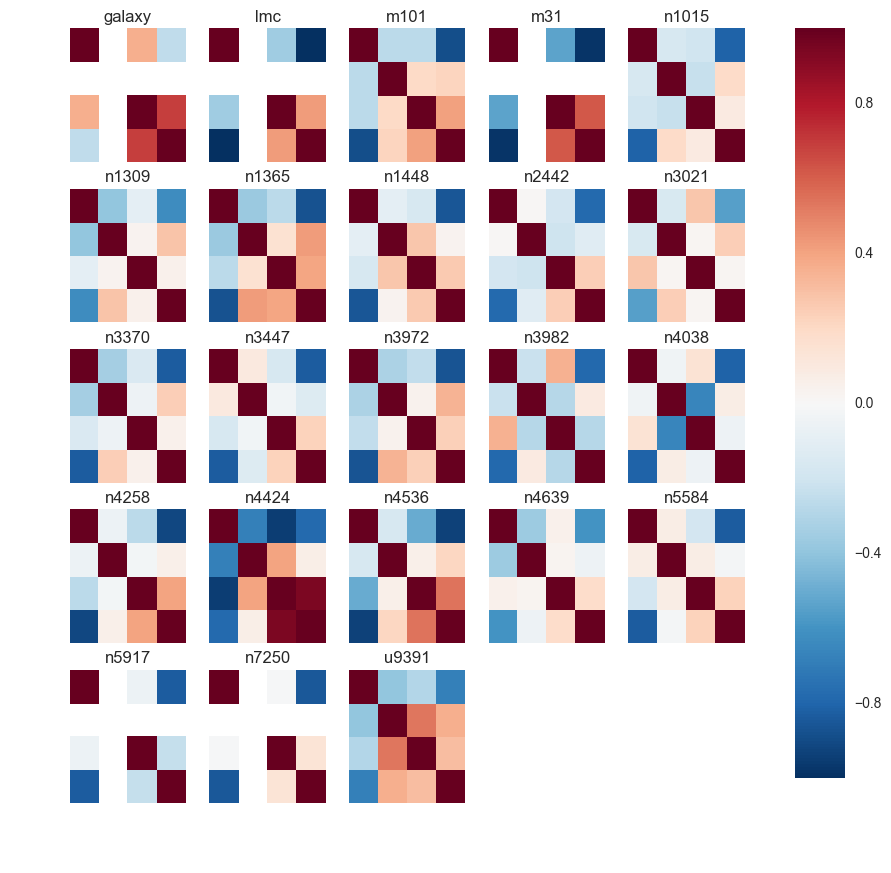

In [11]:
grouped = cepheids_processed.groupby('Field')
fig = figure(figsize = (10,10))
fig.subplots_adjust(right = 0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.75])
for i, (name, group) in enumerate(grouped):
    corr = group[['m_H', 'Z', 'VminusI', 'Period']].corr()
    ax = subplot(5,5,i+1)
    if i == 0:
        seaborn.heatmap(corr, cbar_ax = cbar_ax, vmin = -1, vmax = 1)
    else:
        seaborn.heatmap(corr, cbar = False, vmin = -1, vmax = 1)
    title(name)
    axis('off')
    hold('on')
show()


Two interesting observations:
* the Cepheid metallicity in several of these galaxies is fixed
* while overall all features are positively correlated, by galaxy there is negative correlation
    * argues for joint dependence on galaxy + feature

## A Model
physics says the magnitude of anything should obey the following relationship:
$$m = M + \mu,$$
where $m$ is the observed apparent magnitude, $M$ is intrinsic absolute magnitude, and $\mu$, known as the distance modulus, is related to the (luminosity) distance by $$\mu = 5 \log_{10} \frac{D}{\rm Mpc} - 25.$$

We know that Cepheids (and supernovae) in the same galaxy should have the same $\mu$. Labeling each field with $i$ and each Cepheid with $(i,\alpha)$, we have

$$m_{\alpha,i} = M_{\alpha} + \mu_i$$

$M_{\alpha}$ depends only on the Cepheid properties and represents the absolute (inherent) magntitude of a Cepheid independent of distance. Let's model it as

$$M_{\alpha} = f\left(M_{\rm ceph},\log_{10}P, (V-I), \log_{10} [O/H]\right) + \eta.$$

The term $M_{\rm ceph}$ is important to the notion of a standardizeable candle. Plugging in, we have

# $$m_{\alpha,i} = \mu_i + f\left(M_{\rm ceph},\log_{10}P, (V-I), \log_{10} [O/H]\right) + \eta.$$

For the set of galaxies where $\mu_i$ is known, we can invert this equation to find $M_{\rm ceph}$, a fiducial intrinsic magnitude for Cepheids (the existence and stability of such a quantity is what we mean by standard candle). With this value in hand, the above equation becomes a predictive relationship for galaxies where $\mu_i$ is unknown.

In other words, we can train this model to determine the coefficients $(b, R, \gamma)$ on the data where the $\mu_i$ is known, and use it to predict the $\mu_i$ outside this region. First, let's make sure the data will support training, which is just a check on whether we're extrapolating.

In [12]:
geometric_distances = pd.DataFrame({'lmc' : (18.494, 0.0452),
                                    'n4258' : (29.387, 0.02616*2.17),
                                    'galaxy' : (0,0)
                                    }, 
                                    index = ['mu', 'sigma_mu']
                                   ).T
cephs_and_dist = cepheids_processed.join(geometric_distances, on = 'Field')
cephs_and_dist['TotalError'] = sqrt(cephs_and_dist.TotalError**2 
                                    + cephs_and_dist.sigma_mu.fillna(0)**2)
cephs_and_dist['mu'] = (cephs_and_dist.mu.fillna(0) 
                              + cephs_and_dist.mu_pi.fillna(0)).replace(0, np.nan)
cephs_and_dist.drop(['mu_pi', 'sigma_mu'], axis = 1, inplace = True)

Let's visualize the training (known $\mu$) and prediction (unknown $\mu$) sets, to make sure we're not overextrapolating:

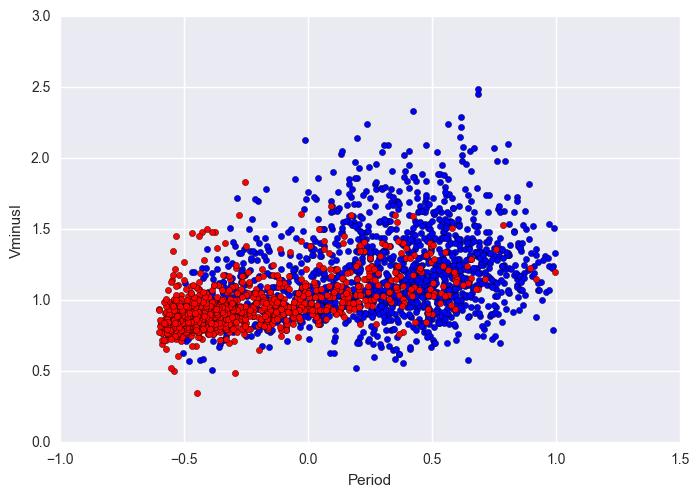

In [13]:
has_distance = cephs_and_dist.mu.notnull()
ax = gca()
cephs_and_dist.loc[~has_distance,:].plot.scatter('Period', 'VminusI', c = 'b', ax = ax)
cephs_and_dist.loc[has_distance, :].plot.scatter('Period','VminusI', c = 'r', ax = ax)


There's definitely overlap, but also some differences. The training data is weighted towards smaller periods, and also has fewer Cepheids with high $V-I$ color. 

# Fitting
We have a bunch of choices on how to do the prediction, which correspond to the various ways we can choose to model $f$.
## 1. Linear Regression
The simplest is perhaps a linear relationship for the various features in the set. The definition of this model is

## $$\mu_i = m_{i,\alpha} + M_{\rm ceph} + b \log_{10} P + R (V-I) + \gamma \log_{10} [O/H]$$

To train this model, we'll move the $m_{i,\alpha}$ over to the other side for the training set, and regress. SKlearn implements several linear models, which differ in the ways in which they obtain the prediction, as well as how they regulate parameters (penalize the complexity of a model). The above model has only 4 parameters, and so we can stick with simple $\chi^2$.



In [14]:
from sklearn.linear_model import LinearRegression ### This is chi2 regression

linear_regression = LinearRegression()

# including \mu_pi for parallax information
known_distance = cephs_and_dist['mu'].notnull()
features = cephs_and_dist.loc[known_distance, ['Period','VminusI', 'Z']]

target = cephs_and_dist.loc[known_distance, 'm_H'] - cephs_and_dist.loc[known_distance, 
                                                                        'mu']
error = cephs_and_dist.loc[known_distance, 'TotalError']

linear_regression.fit(features, target, sample_weight = 1/error**2);


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


We can look at the coefficients of this regression:

In [15]:
regression_coefficients = pd.DataFrame((zip(features.columns, linear_regression.coef_) 
                                       + [('M_ceph', linear_regression.intercept_)]),
                                       columns = ['Feature', 'Coefficient']
                                       )
regression_coefficients

,Feature,Coefficient
0,Period,-3.292732
1,VminusI,0.530998
2,Z,-0.186456
3,M_ceph,-6.116241


The feature $M_{\rm ceph}$ is the standardized candle for Cepheids, and represents the expected absolute magnitude of a Cepheid of period 10 days, $V-I = 0$, and $\log_{10} [0/H] = 8.9$.  

We can fit for the training set to look at the residual:


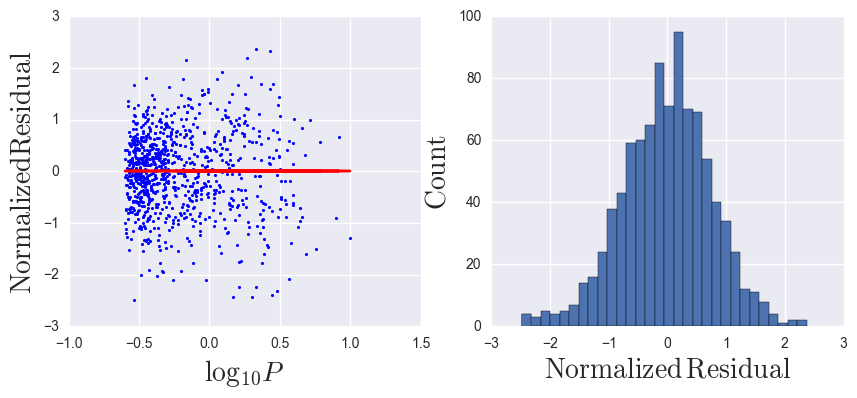

In [16]:
figure(figsize (10,4))
subplot(121)
scatter(features.Period, (target - linear_regression.predict(features))/error, s = 5, lw = 0)
plot(features.Period, zeros(target.size), c = 'r')
xlabel(r'$\log_{10} P$', fontsize = 20)
ylabel(r'${\rm Normalized Residual}$', fontsize = 20)
subplot(122)
hist((target - linear_regression.predict(features))/error, bins = 30);
xlabel(r'${\rm Normalized\, Residual}$', fontsize = 20)
ylabel(r'${\rm Count}$', fontsize = 20)



Now we can make predictions for the records where $m_{\alpha, i} - \mu_i$ is unknown:

In [17]:
features = cephs_and_dist.loc[:, ['Period','VminusI', 'Z']]
target = cephs_and_dist.loc[:, 'm_H'] - cephs_and_dist.loc[:, 
                                                           'mu']
error = cephs_and_dist.loc[:, 'TotalError']

predictions = linear_regression.predict(features);

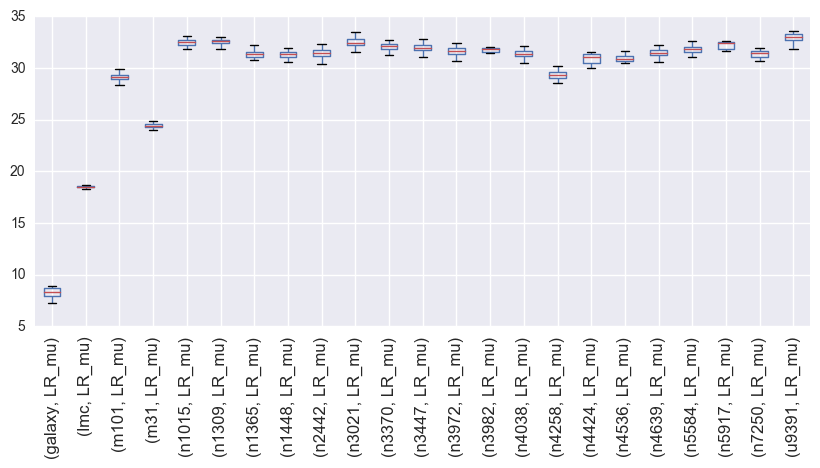

In [18]:
cephs_and_dist['LR_mu'] = cephs_and_dist['m_H'] - predictions
cephs_and_dist[['LR_mu','Field']].groupby('Field').boxplot(subplots = False, rot = 'vertical');

## Error bars

Each galaxy above has a host of Cepheid predictions, the scatter in which is a plausible proxy for errors. This isn't great, because it doesn't give us errors on the parameters, only on the predictions. It also ignores the error in the predicted distance modulus due to uncertainty in the prediction set, which we have to add by hand in an awkward way.

A better way we might get errors from a predictor is **bootstrapping**. Here's an implementation:

In [19]:
from sklearn.ensemble import BaggingRegressor
## Make 1000 Linear Regressors on random samples of the training data with replacement, of the same size as the
## original
bagged_LR = BaggingRegressor(base_estimator = LinearRegression(), 
                             max_samples = 1.0, 
                             max_features = 1.0, 
                             n_estimators = 500
                            )

features = cephs_and_dist.loc[known_distance, ['Period','VminusI', 'Z']]
target = (cephs_and_dist.loc[known_distance, 'm_H'] 
          - cephs_and_dist.loc[known_distance, 'mu']
          )
error = cephs_and_dist.loc[known_distance, 'TotalError']

bagged_LR.fit(features, target, sample_weight= 1/error**2);

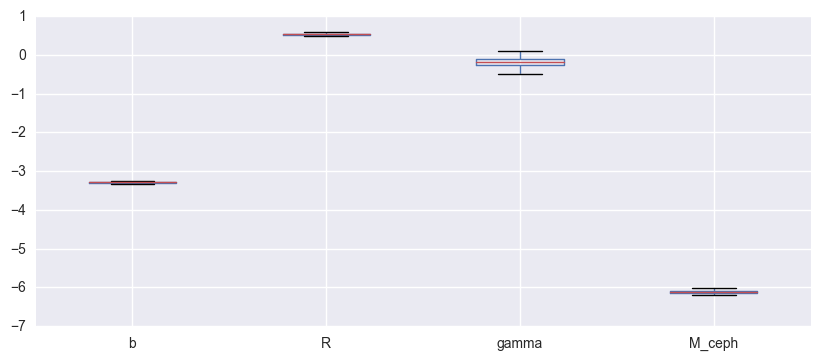

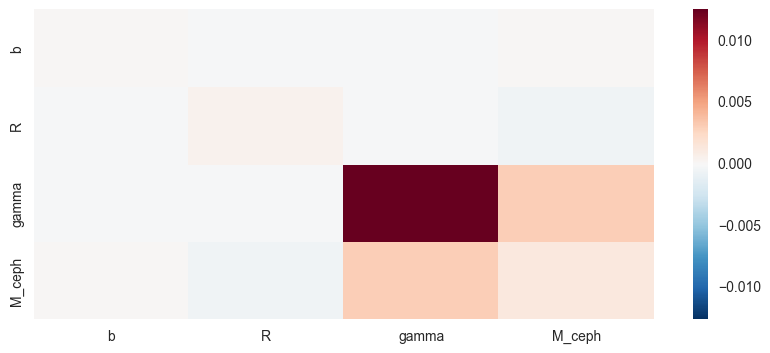

In [20]:
params = pd.DataFrame(columns = ['b', 'R', 'gamma', 'M_ceph'],
                      index = range(bagged_LR.n_estimators)
                     )
for i,fit in enumerate(bagged_LR.estimators_):
    record = array([coef for coef in fit.coef_] + [fit.intercept_])
    #print record
    params.loc[i] = record
#params = params.apply(pd.to_numeric, args = ('coerce'))
params.plot.box()
figure()
seaborn.heatmap(params.apply(pd.to_numeric).cov());

of course, since all we're really doing is $\chi^2$ minimization, we can also estimate the errors via the least squares jacobian. Here's that:


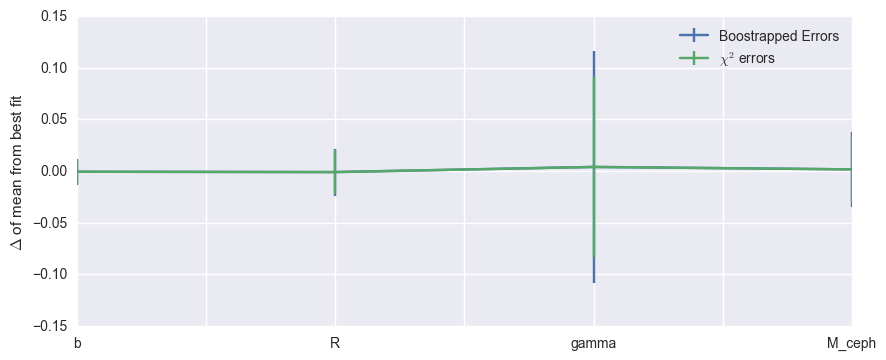

In [21]:
def model(features, b, R, gamma, M_ceph):
    return M_ceph + features.Period * b + features.VminusI * R + features.Z * gamma
from scipy.optimize import curve_fit

best_fit, covariance = curve_fit(model, features, target, sigma = error)
vals = best_fit - params.apply(pd.to_numeric).mean()
figure()
vals.plot(yerr = params.apply(pd.to_numeric).std(), label = 'Boostrapped Errors', ax = gca())
vals.plot(yerr = sqrt(diag(covariance)), label = r'$\chi^2$ errors', ax = gca())
legend()
ylabel(r'$\Delta$ of mean from best fit')

The boostrap method has slightly larger errors; this is expected. You can understand this as being a systematic error associated with the choice of sample. 

We can continue with boostrapping all the way to $H_0$ (probably) but it's a wast of time--we have a statistical model with measured errors, and later on we'll just use them. Let's focus on quick and dirty estimates, to see what complexity's worth modeling.

## Determining $H_0$

The final determination of $H_0$ comes from combining the above Cepheid work with the standardized candles of type Ia supernovae in the Hubble flow (and also the 19 that exist inside the galaxies with Cepheid-estimated distances. The particulars of their standardization are out of the scope of this exposition, but the inferred B-band magnitudes are stored in the *sne* DataFrame.

These inferred values of $m_B^0$, combined with our predictions of $\mu_i$ above, can be fed into the distance modulus equation
$$m_{B,i}^0 = \mu_i + M_0^{\rm SN}$$
for an inference of $M_0^{\rm SN}$. This value, an inferred estimate for the peak absolute $B$-band magnitude of type Ia supernovae, can be used to anchor the empirical type Ia supernovae magnitude-redshift relationship for supernovae in the Hubble flow. For each supernovae in the Hubble flow,
\begin{equation}
M_b^0 = m_b^0 - 5 \log \left( D_{\rm lum}/{\rm Mpc}\right) - 25 ,
\end{equation}
which, when combined with the equation for luminosity distance at cosmic distances,
$$D_{\rm lum} = \frac{c}{H_0} \int_0^z \frac{dz'}{h(z')}$$
gives
\begin{equation}
M_b^0 = 5 \log{H_0} +m_b^0 - 5 \log \left(cz f(z)\right) - 25,
\end{equation}
where the $a_B = f(z) - m_B^0/5$ represents the intercept of the type Ia magnitude-redshift relation. This is fit to order 300 observed $(m_B^0, z)$ pairs to third order,
\begin{align}
a_B &= \frac{1}{z}\int_0^z \frac{dz'}{h(z')} - \frac{m_B^0}{5}  \\
& \simeq 1 + \frac{1}{2} h'(0) z + \frac{1}{6} h''(0)z^2 - \frac{m^0_B}{5},\nonumber
\end{align}
to give $a_B = 0.7162 \pm 0.0018$. In turn, a local determination of $H_0$ is then given by 
## $$H_0 = 10^{0.2 M_b^0 + a_B + 5}.$$

Each supernovae gives an independent estimate of $M_b^0$ via the equation

## \begin{align}
 M_{B,i}^0 &= m_{B,i}^0 - \hat{\mu}_i + \eta^{\rm SN}_{i, {\rm SN}} \\
 \end{align}
 
 with $\hat{\mu}_i =   f\left(M_{\rm ceph},\log_{10}P, (V-I), \log_{10} [O/H]\right) + \eta^{\rm ceph}_{\alpha, i} - m_{\alpha,i}.$



So we can extend our pipeline all the way through to a prediction of $H_0$. Though we won't be able to properly weight or aggregate these predictions, it will give us an idea of tension or unmodeled signal left in the data, and possibly point to more robust ways to model Cepheid magnitudes (more complex ways of modeling $f$).


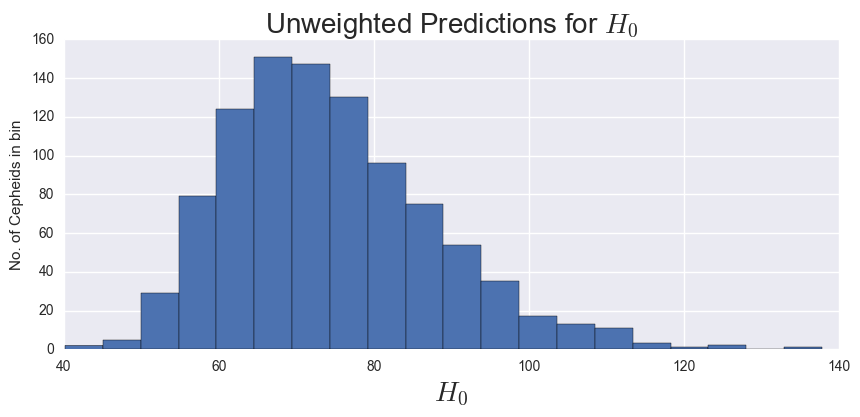

In [22]:

feat_cols=['Period', 'VminusI','Z']

### training set
is_training = cephs_and_dist['mu'].notnull()

### Define a regression learner
linear_regression = LinearRegression()
known_distance = cephs_and_dist['mu'].notnull()
features = cephs_and_dist.loc[known_distance, ['Period','VminusI', 'Z']]

target = cephs_and_dist.loc[known_distance, 'm_H'] - cephs_and_dist.loc[known_distance, 
                                                                        'mu']
error = cephs_and_dist.loc[known_distance, 'TotalError']

linear_regression.fit(features, target, sample_weight = 1/error**2);


### Learn missing mu's
yhat = linear_regression.predict(cephs_and_dist.loc[:,['Period', 'VminusI','Z']])
cephs_and_dist['muhat'] = -yhat + cephs_and_dist.loc[:,'m_H']

### Convert mu's to H_0
# all the data in one frame
data = cephs_and_dist.merge(sne, how = 'left', left_on = 'Field', right_on = 'Host')
Mcephs = data.loc[:,'m^B_0'] - data.loc[:,'muhat']
has_sne = data.SN_err.notnull()
lr_H_0 = H_0 = 10**(0.2 * Mcephs.loc[has_sne] + 0.7162 + 5)
#Mcephs.hist();
H_0.hist(bins = 20);
title(r'Unweighted Predictions for $H_0$', fontsize = 20)
xlabel(r'$H_0$', fontsize = 20)
ylabel(r'No. of Cepheids in bin')

There's some wide values here, though the width of this distribution is not related to the width of the constraint--the closest analogue to that is the constraint on the mean of this distribution, which would be the constraint in the limit of equal errors. Here's a plot of where the extreme lie in the plane:


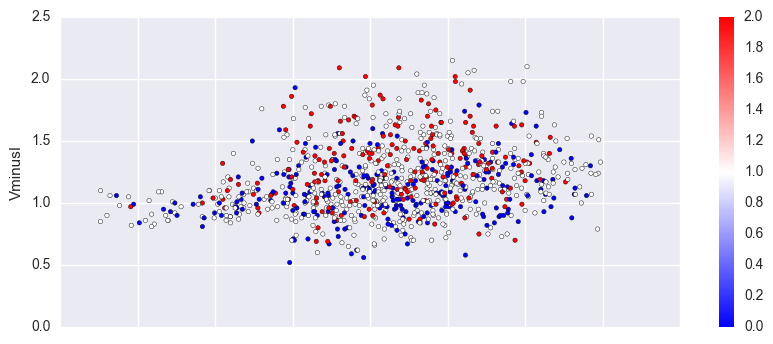

In [23]:
data = data.loc[has_sne]
data['H_0'] = H_0
levels = pd.cut(H_0, [0,65,85,150], labels = ['0','1','2'])
data['levels'] = levels
cmap = get_cmap('bwr', 3)
# norm = Normalize()
# figure()
ax = data.loc[has_sne].plot.scatter('Period','VminusI', c = data['levels'], s = 10, cmap = 'bwr')
# #cbar = colorbar(ax)
# #cbar.set_label(r'$H_0$')

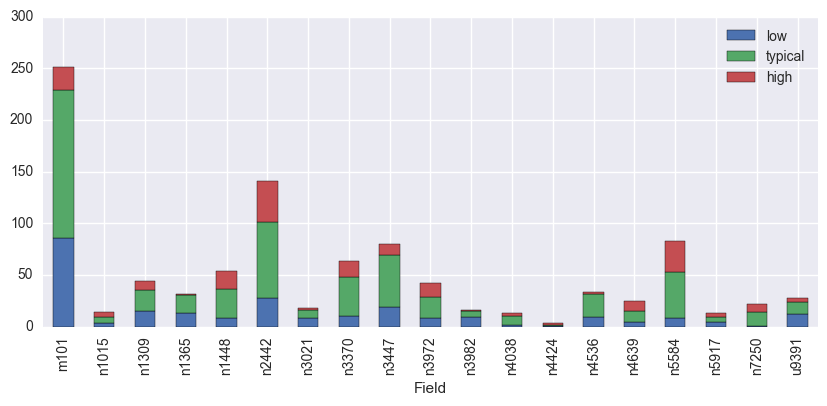

In [24]:
figure();
levels = pd.cut(H_0, [0,65,85,150], labels = ['low','typical','high'])
data['levels'] = levels
counts = pd.get_dummies(data[['Field', 'levels']], columns = ['levels'], 
                        prefix = '', prefix_sep = ''
                       ).groupby('Field').sum();
counts.plot.bar(stacked = True);


## Other Models for $f$

We can try nonlinear models for $f$. A common one is a random forest:

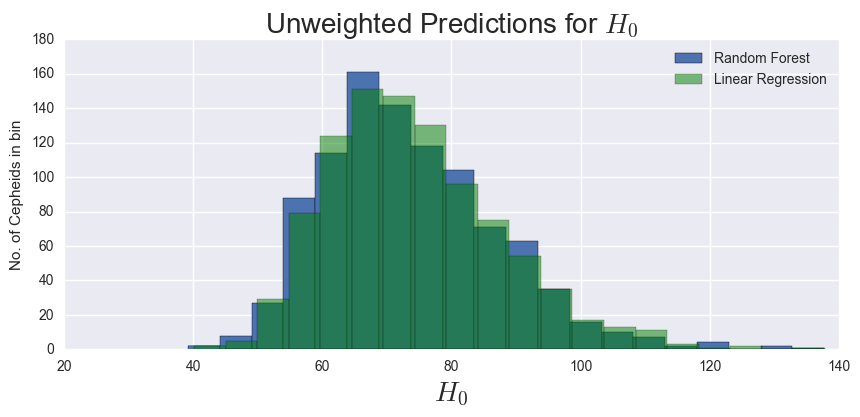

In [25]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor(n_estimators= 5000, n_jobs = -1)



feat_cols=['Period', 'VminusI','Z']
### training set
is_training = cephs_and_dist['mu'].notnull()

### Define a regression learner
#linear_regression = LinearRegression()
known_distance = cephs_and_dist['mu'].notnull()
features = cephs_and_dist.loc[known_distance, ['Period','VminusI', 'Z']]

target = cephs_and_dist.loc[known_distance, 'm_H'] - cephs_and_dist.loc[known_distance, 
                                                                        'mu']
error = cephs_and_dist.loc[known_distance, 'TotalError']

random_forest.fit(features, target, sample_weight = array(1/error**2));


### Learn missing mu's
yhat = random_forest.predict(cephs_and_dist.loc[:,['Period', 'VminusI','Z']])
cephs_and_dist['muhat'] = -yhat + cephs_and_dist.loc[:,'m_H']
data = cephs_and_dist.merge(sne, how = 'left', left_on = 'Field', right_on = 'Host')

### Convert mu's to H_0
Mcephs = data.loc[:,'m^B_0'] - data.loc[:,'muhat']
has_sne = data.SN_err.notnull()
H_0 = 10**(0.2 * Mcephs.loc[has_sne] + 0.7162 + 5)
#Mcephs.hist();
H_0.hist(bins = 20, label = 'Random Forest');
title(r'Unweighted Predictions for $H_0$', fontsize = 20)
xlabel(r'$H_0$', fontsize = 20)
ylabel(r'No. of Cepheids in bin')
lr_H_0.hist(bins = 20, ax = gca(), color = 'g', alpha = 0.5, label = 'Linear Regression')
legend(frameon = False)

In [26]:
import forestci as fci 
# errorbars for random forests from https://arxiv.org/abs/1311.4555 (Wager et. al.)
# This is cheating a bit because the 
in_bag = fci.calc_inbag(features.loc[known_distance, :].shape[0], random_forest)
rf_IJK_variance = fci.random_forest_error(random_forest, 
                        in_bag, 
                        features.loc[known_distance, :],
                        features.loc[:, :]
                        )

## An aside: the dangers of lacking domain knowledge.

I've treated the above in an exploratory fashion, where the details of the analysis are echewed for speed. But you can get really wrong answers if you forget your domains. 

One thing I tried during my exploration was looking to see if the color correction would vary along the line of sight. In principle it should, because the correction depends on things like the dust grain size along the line of sight, which can vary in different galactic hosts.

Here's what I get if I do the R16 analysis (I'm switching to a full statistical model, so the error bars are sensible, though I first noticed this in exploration like that above):

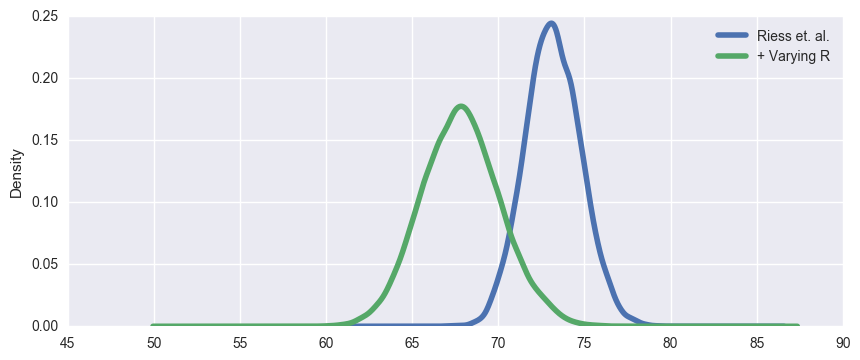

In [48]:
r16 = pd.DataFrame(load_chain('data/chains/r16_treatment_thinned.chain'))
varyR_no_correction = pd.DataFrame(load_chain('data/chains/varyR_no_correction_thinned.chain'))
figure()
ax = gca()
r16['H0'].plot.kde(label = r'Riess et. al.', ax=  ax, lw = 4)
varyR_no_correction['H0'].plot.kde(label = r'+ Varying R', ax = ax, lw =4)
legend()


This is exciting, but wrong. I'll go into it below.

## Expanding the Regression Method
### (and getting Error bars)
Riess et. al use a version of the linear regression method above, with the following changes:
* The coefficient in front of the color is fixed to R = 0.39 using external datasets (n.b. the regime of this validity is questionable)
* The regression algorithm is expanded to semi-supervised learning, where the structure of points inside the galaxies is allowed to contribute to determining the linear coefficients. 
* They allow for a break in the period relationship at $P = 10$ days whose existence is evidenced from both this and external data sets. The evidence is marginal.
* Error bars are estimated through Fisher estimation (Hessian analysis), rather than boostrapping.

None of the above really changes the results, except the aformentioned increase in the errors.

### On top of this,
there are a few more things we can do incorporate more physics.
* The correction for color include the total measured $(V-I)$. The correction is due to reddening effects along the line of sight, so we should correct this term by subtracting out intrinsic Cepheid color $(V-I)^0$, due to the fact that Cepheids have a different brightness in different frames.
    * Additional data from Tamaan et. al (http://www.aanda.org/articles/aa/abs/2003/23/aah4210/aah4210.html) 
* We can try to look for more general breaks in the linear behavior beyond the break at $P = 10$ days. We'll do this with a Gaussian Mixture Model.
* The above introduces nonlinear effects, which means we'll switch to a more robust method of measuring error bars through MCMC sampling of the underlying model parameter distributions.





In [49]:
r16 = pd.DataFrame(load_chain('data/chains/r16_treatment_thinned.chain'))
base = pd.DataFrame(load_chain('data/chains/base_thinned.chain'))
manypops = pd.DataFrame(load_chain('data/chains/base_manypops_thinned.chain'))
varyR = pd.DataFrame(load_chain('data/chains/varyR_thinned.chain'))
varyR_manypops = pd.DataFrame(load_chain('data/chains/varyR_manypops_thinned.chain'))


The general consistency we see in our exploratory analysis persists. Various ideas to expand the model fail to change the result.

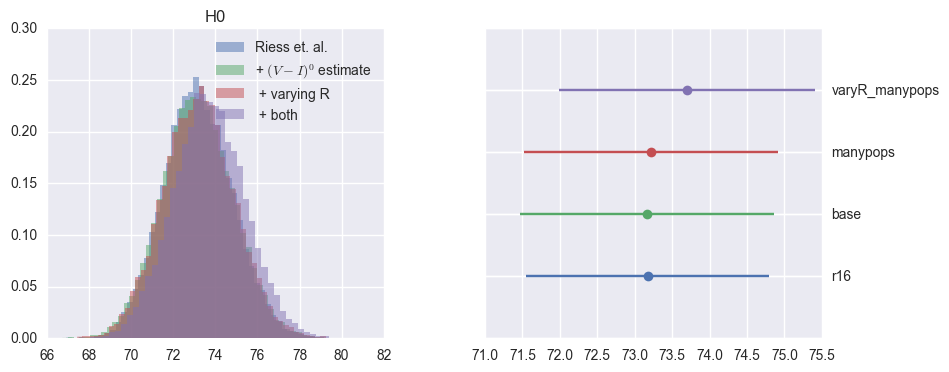

In [60]:
fig = figure(figsize = (10,4))
ax = subplot(121)
r16.hist('H0', bins = 50, normed = True, label = r'Riess et. al.', ax=  ax, alpha = 0.5, lw = 0)
base.hist('H0', bins = 50, normed = True, label = r'+ $(V-I)^0$ estimate', ax = ax,alpha = 0.5, lw = 0)
manypops.hist('H0', bins = 50, normed = True, label = r' + varying R', ax = ax,alpha = 0.5, lw = 0)
varyR_manypops.hist('H0', bins = 50, normed = True, label = r' + both', ax = ax,alpha = 0.5, lw = 0)
legend(frameon = False)
ax = subplot(122)
ax.set_yticklabels([''] * 5)
subplot(122).twinx()
chainnames = ['r16', 'base', 'manypops', 'varyR_manypops']
for i,chainname in enumerate(chainnames):
    chain = eval(chainname)
    errorbar(chain.H0.mean(), i, xerr= chain.H0.std(), label = chainname, fmt = 'o')
ylim(-1, i+1)
#legend(frameon = False)
xlabel(r'$H_0$', fontsize = 20)
gca().set_yticklabels([''] + chainnames);

The first change was trying to jointly estimate the intrinsic color $(V-I)^0$ alongside the total color $V-I$. If Cepheids have different intrinsic color distributions in different galaxies, this could have caused a shift in $H_0$. We modeled it as
$$(V-I)^0 = C_0 + C_P (\log_{10} P - 1) + C_Z (\log_{10} [O/H]-8.9).$$
Here are the constraints on those parameters:


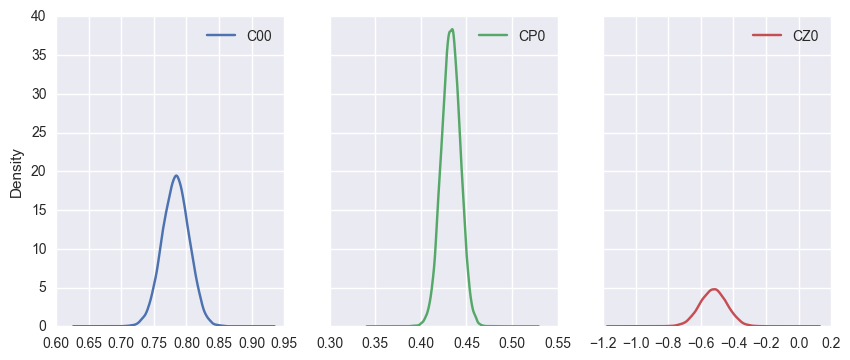

In [67]:
#subplots(221)
base[['C00', 'CP0', 'CZ0']].plot.kde(subplots = True, sharey = True, sharex = False, layout = (1,3));


There is some color dependence in terms of the other Cepheid variables, but the lever arm for both Cepheid and metallicity are too small for it to effect the $H_0$ constraint.

The next feature is varying R. Unlike above, we do this *after* subtracting the intrinsic color, because it's probably not kosher to use the Cepheid sample to fit for a difference in Cepheid intrinsic color.

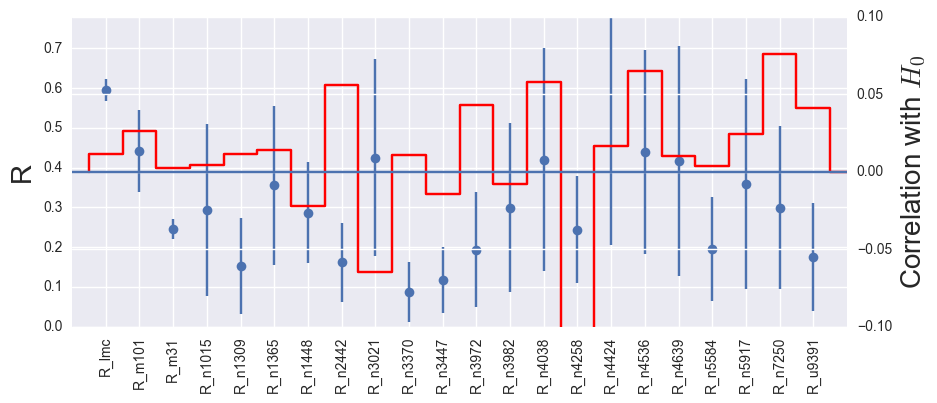

In [52]:
r_vals = [col for col in varyR.columns if col.startswith('R_')]
correlations = varyR.corr().loc[r_vals , 'H0']
vals = varyR[r_vals].mean() + 0.39
err = varyR[r_vals].std()

ax1 = subplot(111)
errorbar(arange(len(r_vals)), vals, yerr= err, fmt = 'o')
xlim(-1, 22)
ylim(0.39 - 0.39, 0.39 + 0.39)
xticks(arange(0,22),correlations.index, rotation = 'vertical')
ylabel('R', fontsize = 20)

ax2 = twinx(ax1)
plot(arange(-1, 23)+0.5, [0] + correlations.tolist() + [0], ls = 'steps', c = 'r')
plot(arange(-1, 24), zeros(25))
ylim(-.1, .1)
xlim(-1, 22);
ylabel('Correlation with $H_0$', fontsize =20)


I need to use priors here to regularize the variations. The only hosts with enough Cepheid power to make a strong determination of $R$ are the LMC and M31. M31 is neither an anchor nor a type Ia host (its purpose is to help constrain $f$), while the departures from $R = 0.39$ in the LMC doesn't effect the determination of $H_0$ because there isn't a color extrapolation in the determination. It was conceivable that tension inside the LMC Cepheids could have allowed this model to widen or move the constraint, so this is a good test of the internal consistency of the Cepheid anchoring. It passes.

Finally, we try to account for some nonlinearity. In the exploratory analysis I used a random forest approach. That's too slow for a chain, so I opted for some clustering via a Gaussian Mixture model. This looks for subpopulations in the Cepheid feature space drawn from Gaussians:

In [68]:
from sklearn.mixture import GaussianMixture
features = cepheids[['Period', 'VminusI']]
bic_array = []
for n_classes in arange(1,15):
    model = GaussianMixture(n_components = n_classes, max_iter = 100, n_init = 40, init_params= 'random')
    estimate = model.fit(features)
    bic_array += [model.bic(features)]

(0, 16)

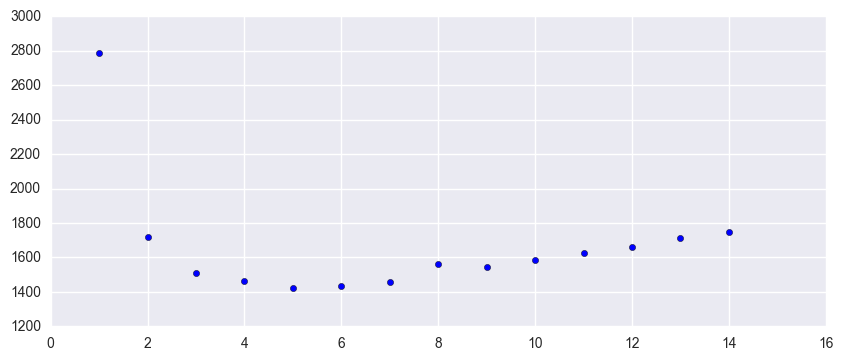

In [69]:
scatter(arange(1,15), bic_array)
xlim(0,16)

In [70]:
n_classes = 6
gmm = GaussianMixture(n_components = n_classes, max_iter = 100, n_init = 100, init_params= 'random')
gmm.fit(features);

We can use the Bayesian Information Criterion (this is just the maximum likelihood value of a Gaussian likelihood of the mixture components with respect to the data) to select how many populations to keep. The minimimum BIC comes with either 5 or 6 components depending on the run; I used 6.

Here's how the cepheids fall in that distribution:

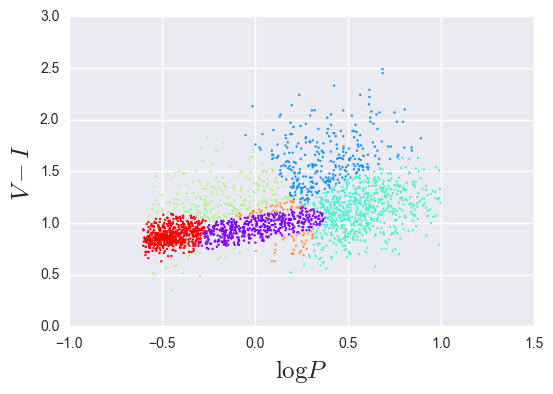

In [73]:
figure(figsize = (6,4))
cmap = get_cmap('rainbow', 6)
cepheids['population'] = gmm.predict(features)
scatter(cepheids.Period, cepheids.VminusI, s= 3, lw = 0, cmap = cmap, c = cepheids.population)
xlabel(r'$\log P$', fontsize = 18)
ylabel(r'$V-I$', fontsize = 18);

Those cutoffs are harsh, though; there's a lot of overlap of the populations, as seen below. Instead of assigning a Cepheid to a population, we just let them all live in a mixture of each population, with the weights decided by the relative probabilitiy of being drawn from that population.

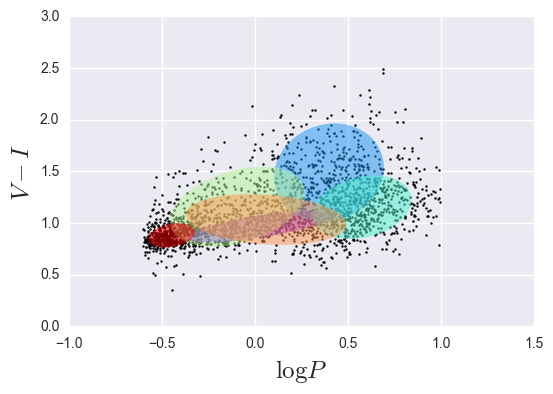

In [75]:
from numpy.linalg import norm
figure(figsize = (6,4))
ax = gca()
scatter(cepheids.Period, cepheids.VminusI, s= 3, 
        lw = 0, color = 'k'
       )

for pop in arange(6):
    v, w = eigh(gmm.covariances_[pop][:2,:2])
    u = w[0]/norm(w[0])
    angle = arctan2(u[1], u[0]) * 180/pi
    v = 2 * sqrt(2) * sqrt(v)
    ell = mpl.patches.Ellipse(gmm.means_[pop, :2], 
                              v[0], v[1], 180 + angle,
                              color = cmap(pop))
    ell.set_alpha(0.5)
    ax.add_artist(ell)

xlabel(r'$\log P$', fontsize = 18)
ylabel(r'$V-I$', fontsize = 18);

We can look at the distribution of the different populations among the various Galaxies:

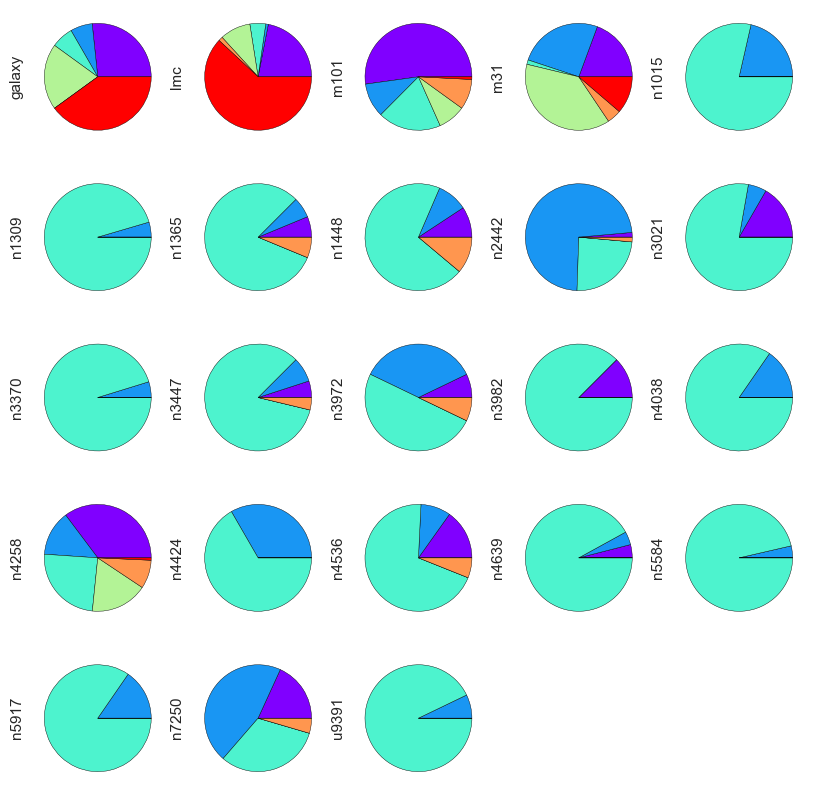

In [95]:
figure(figsize = (10,10))
counts = pd.get_dummies(cepheids[['Field', 'population']], columns = ['population']).groupby('Field').sum()
counts.T.plot.pie(subplots = True, legend = False, layout = (5,5), labels = ['']*6, ax = gca(), cmap = cmap)
gca().set_yscale('log');
#cephs.groupby(['Field', 'population']).count().loc[[(field,i) for i in arange(6)], :]
#ylim(0,100);
#counts.plot.bar?

These populations do behave differently, but the posteriors for each population is consistent. Especially in the center, where the weight of the $H_0$ inference lies.

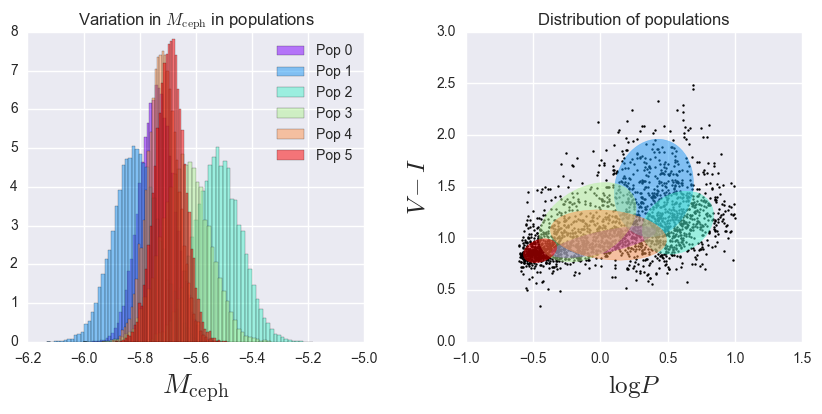

In [97]:
cols = [col for col in manypops.columns if col.startswith('M_ceph')]
figure(figsize = (10,4))
ax = subplot(121)
for i, col in enumerate(cols):
    if col == 'M_ceph0':
        manypops.hist(col, bins = 50, alpha = 0.5, color = cmap(i/6.0), ax = ax, normed = True, label = 'Pop '+col[-1])
    else:
        manypops['temp'] = chain[col] + chain['M_ceph0']
        manypops.hist('temp',bins = 50, alpha = 0.5, color = cmap(i/6.0), ax = ax, normed = True, label = 'Pop '+col[-1])
        manypops.drop(['temp'], axis = 1)
xlabel(r'$M_{\rm ceph}$', fontsize = 20)
legend(frameon = False)
ax.set_title(r'Variation in $M_{\rm ceph}$ in populations')

ax = subplot(122)
scatter(cepheids.Period, cepheids.VminusI, s= 3, 
        lw = 0, color = 'k'
       )

for pop in arange(6):
    v, w = eigh(gmm.covariances_[pop][:2,:2])
    u = w[0]/norm(w[0])
    angle = arctan2(u[1], u[0]) * 180/pi
    v = 2 * sqrt(2) * sqrt(v)
    ell = mpl.patches.Ellipse(gmm.means_[pop, :2], 
                              v[0], v[1], 180 + angle,
                              color = cmap(pop))
    ell.set_alpha(0.5)
    ax.add_artist(ell)
xlabel(r'$\log P$', fontsize = 18)
ylabel(r'$V-I$', fontsize = 18);
title('Distribution of populations')